In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import itertools
import warnings
warnings.filterwarnings('ignore')

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 几个检验

### 1、序列平稳性检验 --单位根检验

In [9]:
def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series. 单位根检验
    
    Null hypothesis: the series is non-stationary.  原假设：有单位根 （不平稳）
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity). p<显著性水平，则拒绝原假设，说明是单位根平稳
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

## 2、acf、pacf图

In [2]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

## 3、模型残差统计

In [8]:
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0] # 原假设：是正态的
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0] # 原假设：没有序列相关性
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    # 原假设：没有序列相关性
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

## 4、模型参数网格搜索

In [3]:
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    # # Initialize a DataFrame to store the results
    # results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
    #                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing

            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic

            # this_model.loc[mod_num, 'het_method'] = stat['het_method']
            # this_model.loc[mod_num, 'het_stat'] = stat['het_stat']
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            # this_model.loc[mod_num, 'norm_method'] = stat['norm_method']
            # this_model.loc[mod_num, 'norm_stat'] = stat['norm_stat']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            # this_model.loc[mod_num, 'skew'] = stat['skew']
            # this_model.loc[mod_num, 'kurtosis'] = stat['kurtosis']
            # this_model.loc[mod_num, 'sercor_method'] = stat['sercor_method']
            # this_model.loc[mod_num, 'sercor_stat'] = stat['sercor_stat']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

## 数据建模

In [40]:
# Step 1: Import the data series
liquor = pd.read_csv('liquor.csv', header=0, index_col=0, parse_dates=[0])

# Step 1b: Create the training and testing series before analyzing the series
n_sample = liquor.shape[0]
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train

liquor_train = liquor.iloc[:n_train]['Value']
liquor_test  = liquor.iloc[n_train:]['Value']
print(liquor_train.shape)
print(liquor_test.shape)
print("Training Series:", "\n", liquor_train.tail(), "\n")
print("Testing Series:", "\n", liquor_test.head())

(279,)
(14,)
Training Series: 
 Period
2014-11-01    4133
2014-12-01    5606
2015-01-01    3576
2015-02-01    3517
2015-03-01    3881
Name: Value, dtype: int64 

Testing Series: 
 Period
2015-04-01    3864
2015-05-01    4369
2015-06-01    4241
2015-07-01    4524
2015-08-01    4248
Name: Value, dtype: int64


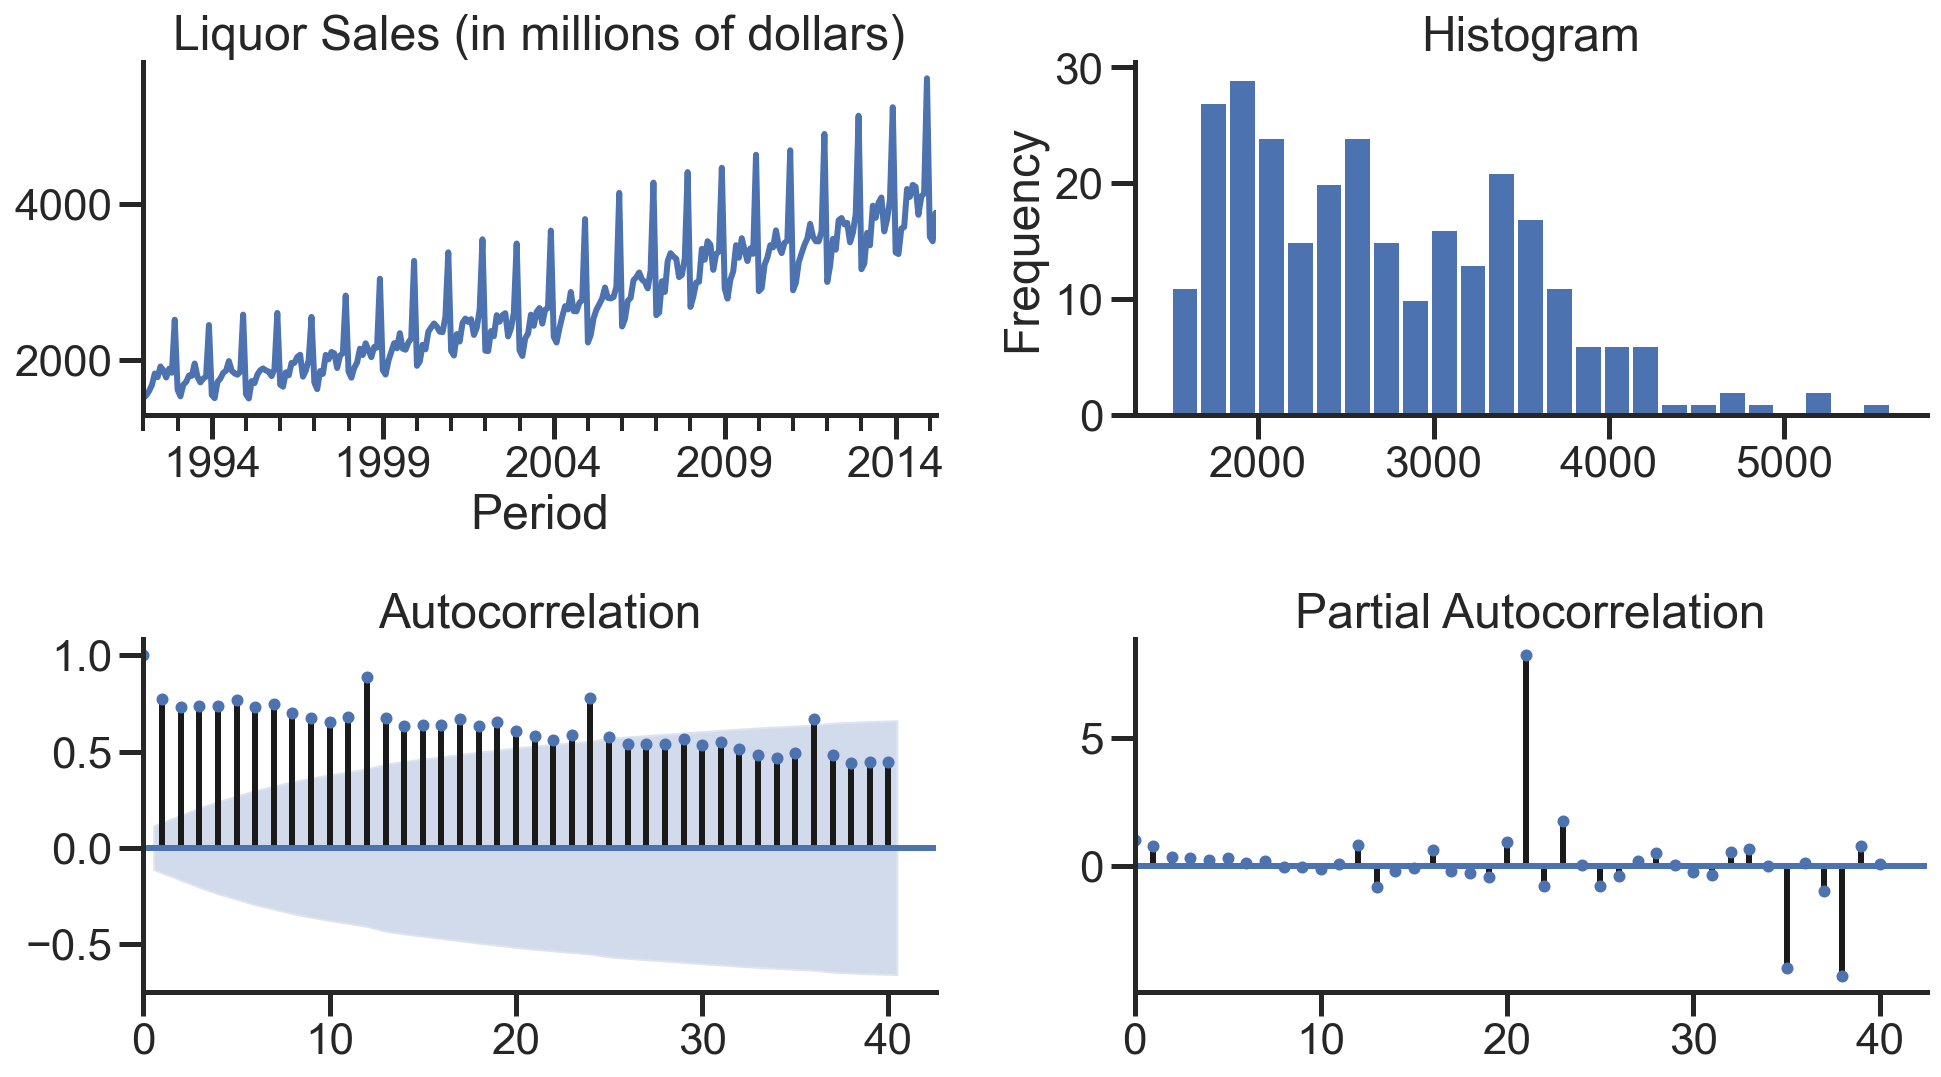

In [6]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
#tsplot(liquor_train, title='Liquor Sales (in millions of dollars), 2007-2016', lags=??);

tsplot(liquor_train, title='Liquor Sales (in millions of dollars)', lags=40);

In [11]:
# 检验平稳性

test_stationarity(liquor_train)

Test Statistic                  1.84537
p-value                         0.99843
#Lags Used                     16.00000
Number of Observations Used   262.00000
Critical Value (1%)            -3.45556
Critical Value (5%)            -2.87264
Critical Value (10%)           -2.57268
dtype: float64

In [12]:
# Take first difference of the series
test_stationarity(liquor_train.diff().dropna())

Test Statistic                 -3.28580
p-value                         0.01553
#Lags Used                     16.00000
Number of Observations Used   261.00000
Critical Value (1%)            -3.45566
Critical Value (5%)            -2.87268
Critical Value (10%)           -2.57271
dtype: float64

In [13]:
# Take log of the series
liquor_train['lnliquor'] = np.log(liquor_train)

test_stationarity(liquor_train['lnliquor'])

Test Statistic                  0.41949
p-value                         0.98221
#Lags Used                     16.00000
Number of Observations Used   262.00000
Critical Value (1%)            -3.45556
Critical Value (5%)            -2.87264
Critical Value (10%)           -2.57268
dtype: float64

In [14]:
# Take first difference of the log series
liquor_ln_diff = liquor_train['lnliquor'].diff()
liquor_ln_diff = liquor_ln_diff.dropna()

test_stationarity(liquor_ln_diff)

Test Statistic                 -4.10740
p-value                         0.00094
#Lags Used                     16.00000
Number of Observations Used   261.00000
Critical Value (1%)            -3.45566
Critical Value (5%)            -2.87268
Critical Value (10%)           -2.57271
dtype: float64

In [15]:
# run model grid search

p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 1
q_max = 2

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 1
sD_max = 1
sQ_max = 1

s=12

# trends=['n', 'c']
trends=['n']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(liquor['Value'],
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

In [16]:
# choose a model

df_results.sort_values(by='bic').head(10)

,p,d,q,sP,sD,sQ,s,trend,enforce_stationarity,enforce_invertibility,simple_differencing,aic,bic,het_p,norm_p,sercor_p,dw_stat,arroots_gt_1,maroots_gt_1,datetime_run
104,2,1,0,0,1,1,12,n,True,True,False,3238.62878,3253.16794,0.00059,0.90347,0.00000,1.96594,True,True,2021-11-22 21:39:33
107,2,1,0,1,1,1,12,n,True,True,False,3236.25405,3254.42800,0.00088,0.98144,0.00000,1.97321,True,True,2021-11-22 21:39:36
106,2,1,0,1,1,0,12,n,True,True,False,3241.59139,3256.13055,0.00059,0.72989,0.00000,1.96188,True,True,2021-11-22 21:39:35
119,2,1,2,0,1,1,12,n,True,True,False,3236.18607,3257.99480,0.00249,0.92919,0.00000,1.97124,True,True,2021-11-22 21:39:46
123,2,1,2,1,1,1,12,n,True,True,False,3232.87966,3258.32319,0.00413,0.74454,0.00000,1.96801,True,True,2021-11-22 21:39:54
111,2,1,1,0,1,1,12,n,True,True,False,3240.60686,3258.78081,0.00055,0.88584,0.00000,1.97476,True,True,2021-11-22 21:39:39
115,2,1,1,1,1,1,12,n,True,True,False,3238.25162,3260.06036,0.00086,0.97870,0.00000,1.97608,True,True,2021-11-22 21:39:43
103,2,1,0,0,1,0,12,n,True,True,False,3249.16711,3260.07148,0.00074,0.64390,0.00000,1.95485,True,True,2021-11-22 21:39:32
114,2,1,1,1,1,0,12,n,True,True,False,3243.55838,3261.73233,0.00055,0.70209,0.00000,1.97271,True,True,2021-11-22 21:39:41
122,2,1,2,1,1,0,12,n,True,True,False,3240.05785,3261.86659,0.00260,0.99988,0.00000,1.97764,True,True,2021-11-22 21:39:52


In [42]:
mod = sm.tsa.statespace.SARIMAX(liquor_train, order=(2,1,0), seasonal_order=(0,1,1,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                  279
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1528.633
Date:                              Mon, 22 Nov 2021   AIC                           3065.266
Time:                                      21:51:43   BIC                           3079.600
Sample:                                  01-01-1992   HQIC                          3071.024
                                       - 03-01-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8525      0.053    -16.085      0.000      -0.956      -0.749
ar.L2         -0.52

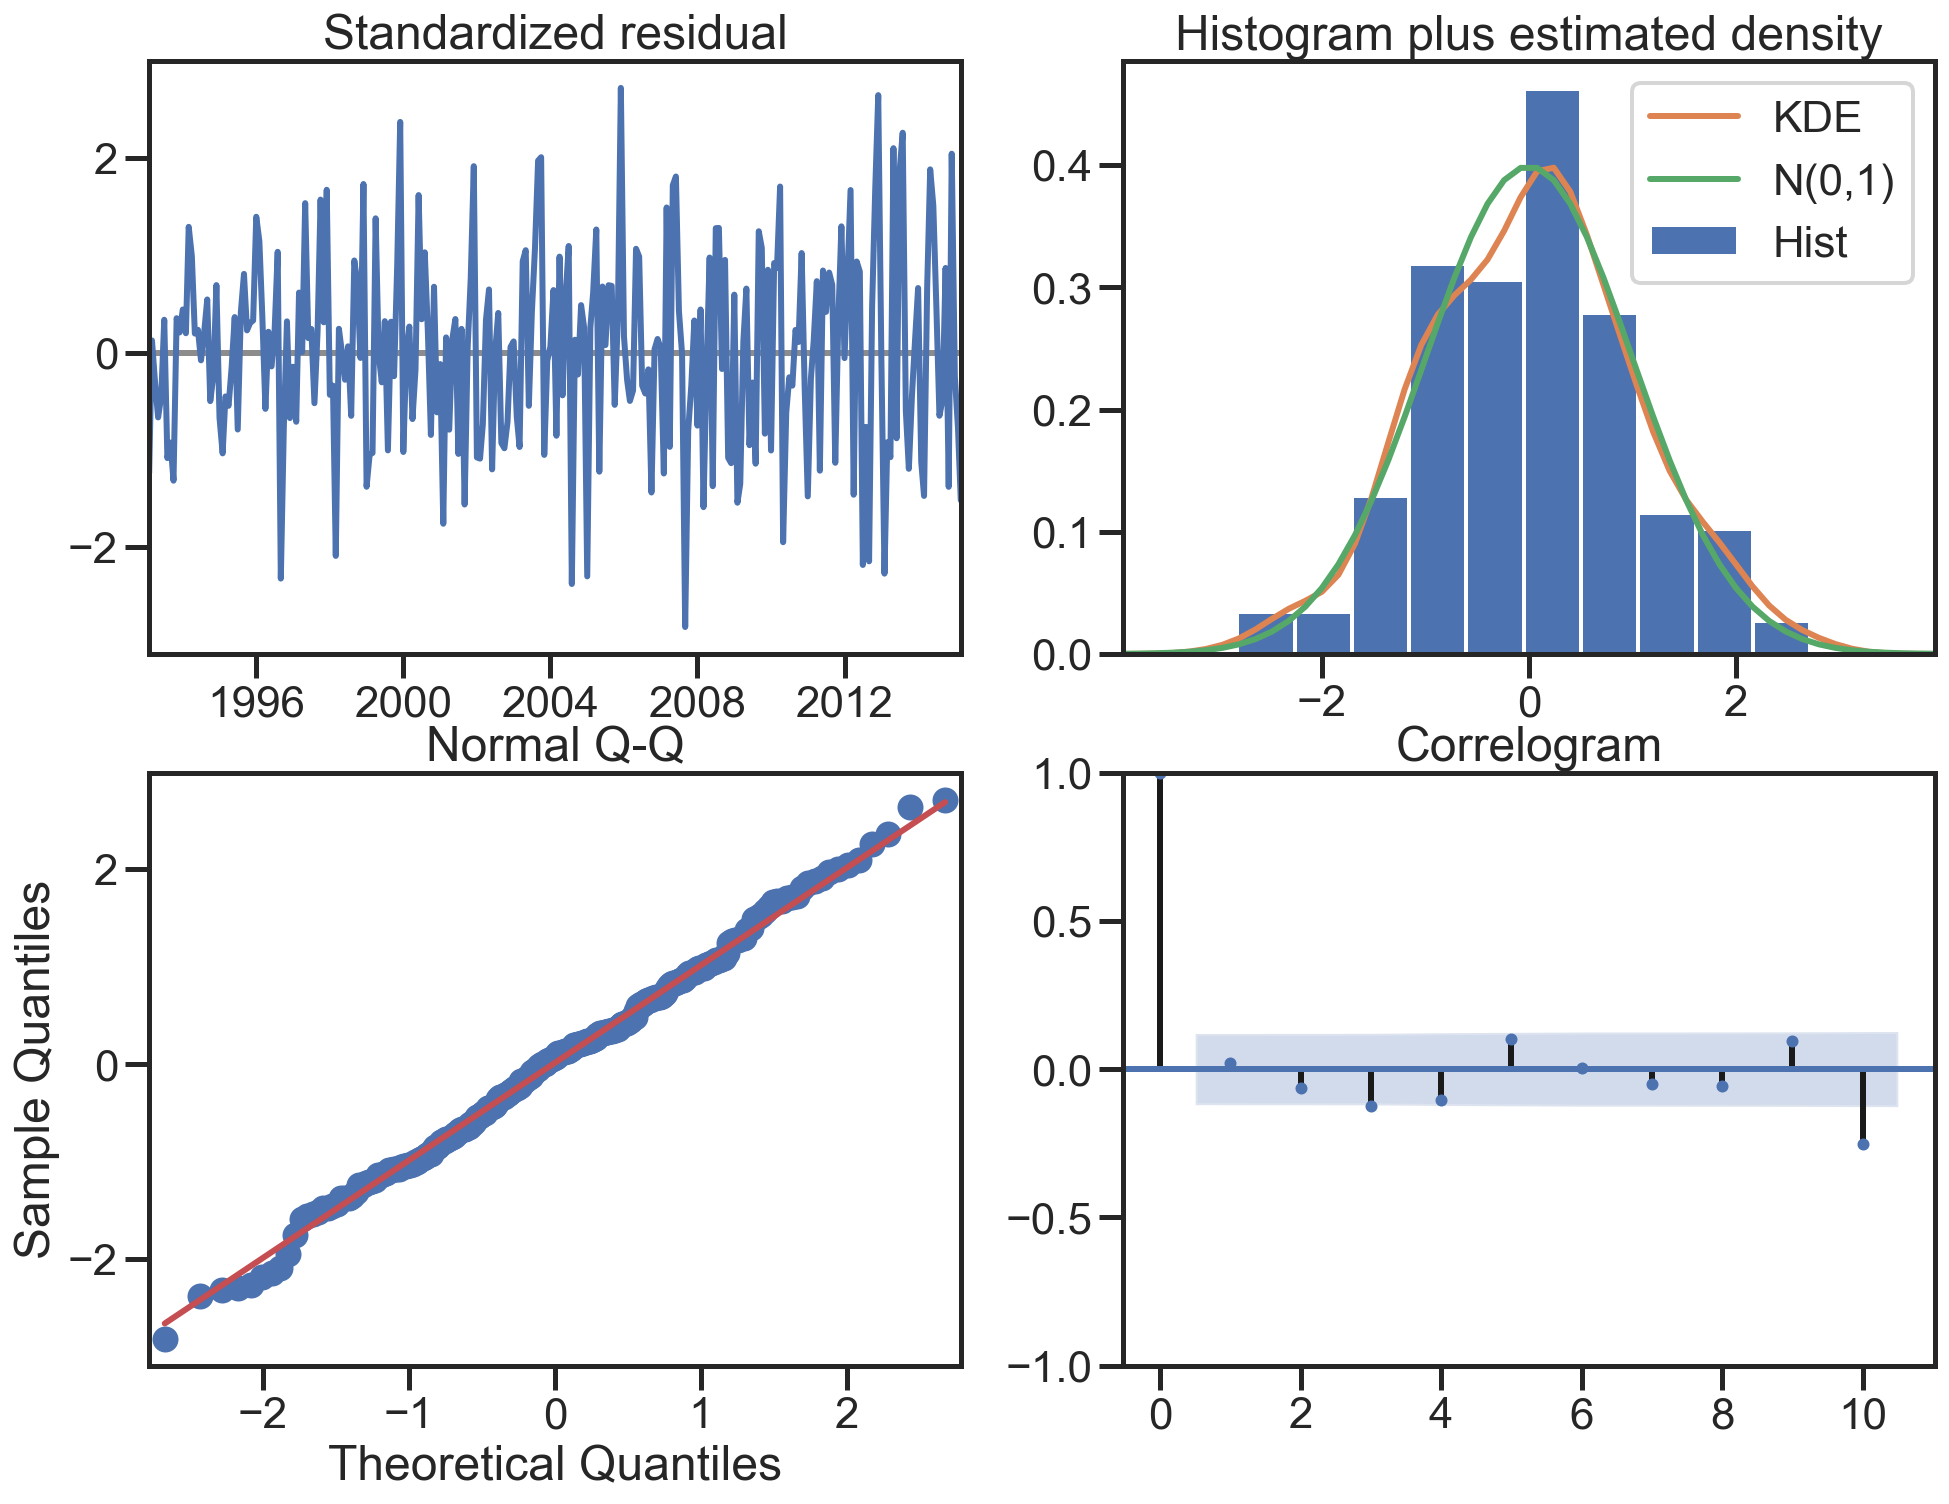

In [43]:
sarima_fit2.plot_diagnostics(figsize=(16, 12));

In [45]:
model_resid_stats(sarima_fit2)

Test heteroskedasticity of residuals (breakvar): stat=1.857, p=0.004

Test normality of residuals (jarquebera): stat=0.084, p=0.959

Test serial correlation of residuals (ljungbox): stat=132.350, p=0.000

Durbin-Watson test on residuals: d=1.95
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


{'het_method': 'breakvar',
 'het_stat': 1.8573428340343776,
 'het_p': 0.0038571744321442944,
 'norm_method': 'jarquebera',
 'norm_stat': 0.08434161996881885,
 'norm_p': 0.9587060100274346,
 'skew': 0.017567930858389896,
 'kurtosis': 2.920154890918918,
 'sercor_method': 'ljungbox',
 'sercor_stat': 132.34990105701291,
 'sercor_p': 8.168775347429916e-12,
 'dw_stat': 1.9459981742995578,
 'arroots_outside_unit_circle': True,
 'maroots_outside_unit_circle': True}

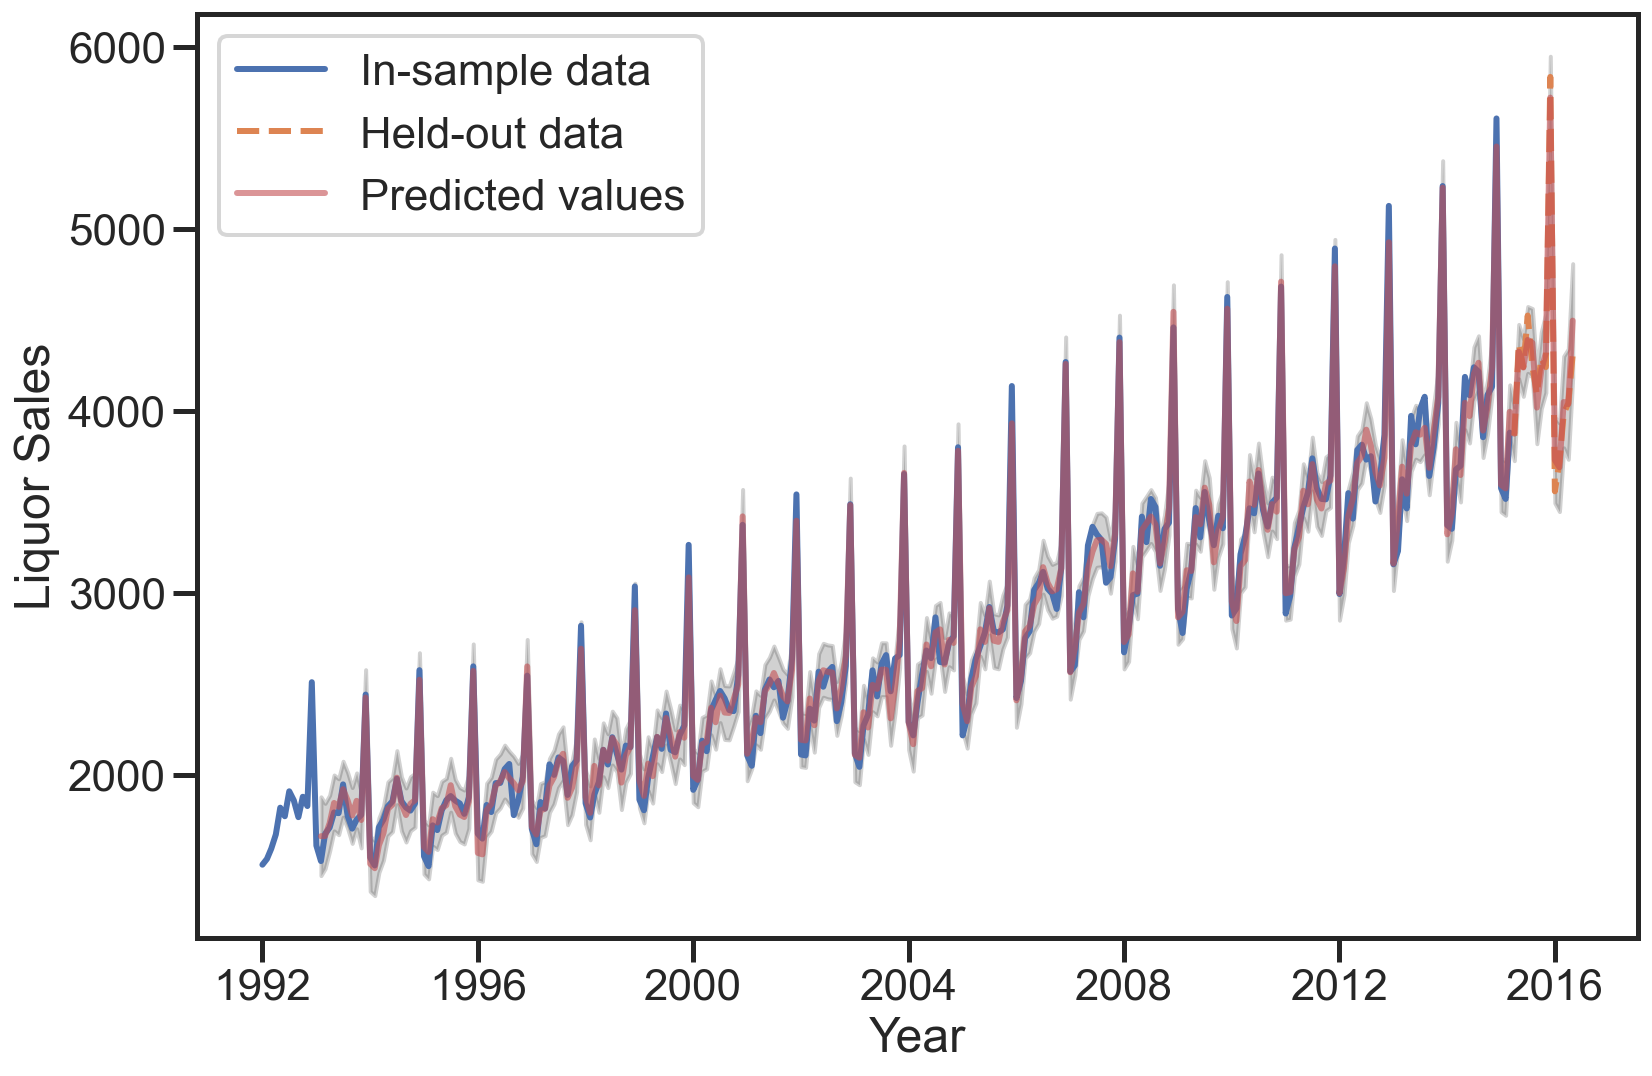

In [44]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(liquor_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(liquor_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = liquor_train.index[sarima_fit2.loglikelihood_burn]
pred_end = liquor_test.index[-1]
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Liquor Sales")
ax1.legend(loc='best');
fig.tight_layout();

### 5.2 Where to go from here

#### Jupyter notebooks, presentations, blog posts

- Example notebooks using SARIMAX models:
    - SARIMAX introduction
        - http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
    - Model selection, missing data
        - http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_internet.html
- "Time series analysis and forecasting with statsmodels" presentation, by a statsmodels lead contributor
    - https://josef-pkt.github.io/pages/slides/slides_forecasting.slides.html
- Time series analysis using Pandas and statsmodels, by a statsmodels lead contributor
    - https://tomaugspurger.github.io/modern-7-timeseries.html
- Time series analysis using Pandas and statsmodels
    - https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- Simple example of SARIMA forecast (based on the analyticsvidhya.com post)
    - http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/


#### Free textbooks available online

- Forecasting: principles and practice (free textbook, with R code)
    - https://www.otexts.org/fpp/
- Time Series Analysis and Its Applications: With R Examples (Shumway & Stoffer, EZ time series edition)
    - http://www.stat.pitt.edu/stoffer/tsa4/

